In [31]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tsa.api import VAR
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

np.random.seed(42)

### Analisi Esplorativa dei dati

In [32]:
df = pandas.read_csv('data/homicide_df.csv')

display(df)

,geo,year,homicides,poverty,neet,education,unemployment,income,inequity
0,Austria,2016,0.56,14.964810,8.091438,34.540870,3.828207,24400,4.09
1,Belgium,2016,1.55,25.110680,13.799563,50.108248,5.316225,22267,3.85
2,Bulgaria,2016,1.10,29.330514,16.024476,23.464412,3.648430,3212,7.69
3,Cyprus,2016,1.30,1.917201,1.526974,4.767553,0.729554,14132,4.88
4,Czechia,2016,0.62,13.086765,11.714766,34.405528,2.743999,7905,3.50
...,...,...,...,...,...,...,...,...,...
157,Portugal,2021,0.80,23.068084,9.783339,48.916697,4.531231,11115,5.66
158,Romania,2021,0.99,66.245734,38.979374,44.739872,6.144532,4914,7.14
159,Sweden,2021,1.09,17.852387,6.227577,51.169924,6.746542,25925,4.04
160,Slovenia,2021,0.43,2.783850,1.539553,10.102000,0.653783,15415,3.24


<Axes: >

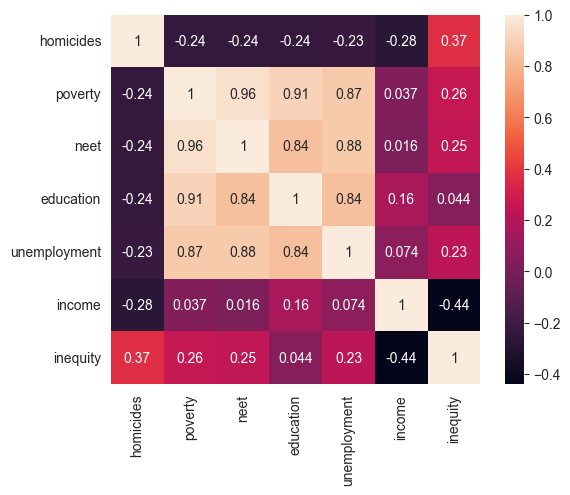

In [33]:
# Correlation Matrix

corrmat = df.drop(columns=["geo", "year"]).corr()

sns.heatmap(corrmat, square=True, annot=True)

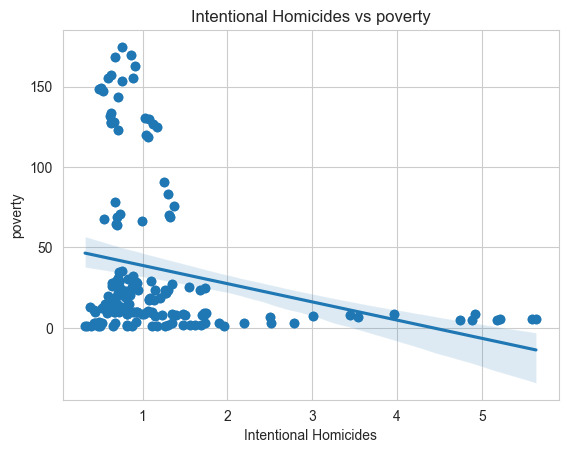

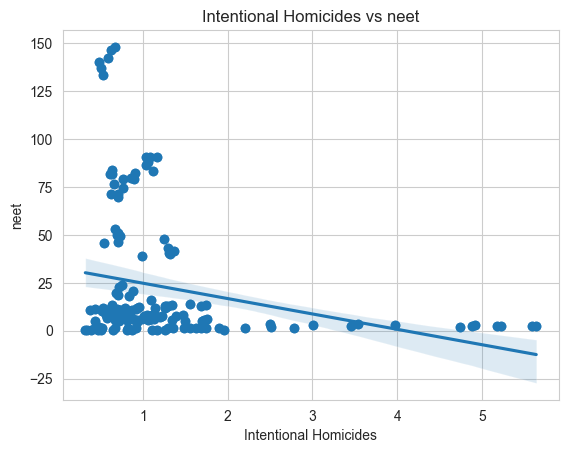

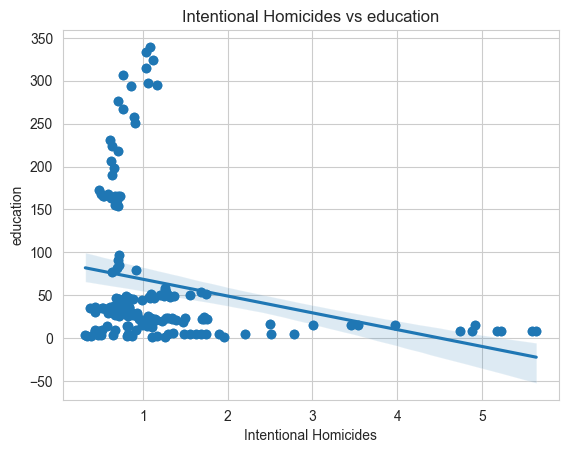

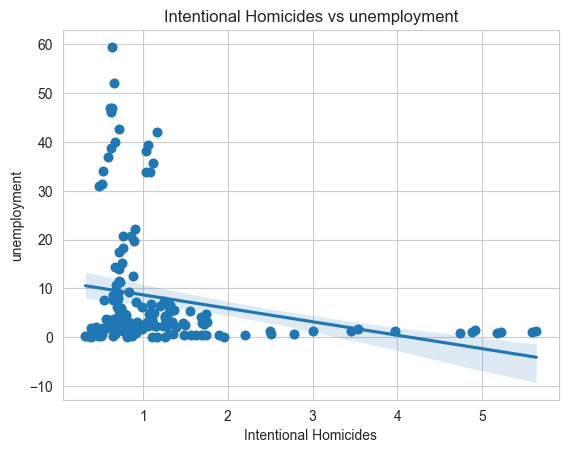

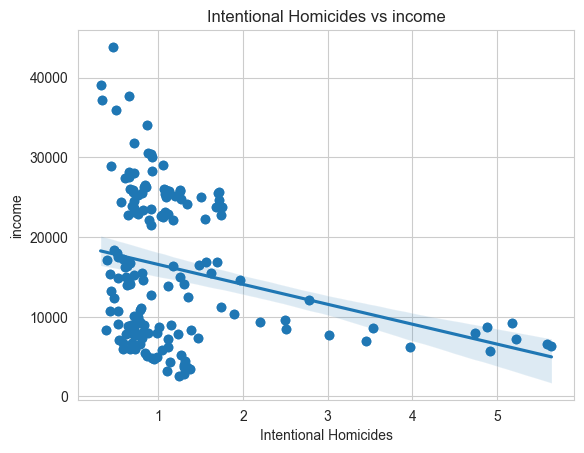

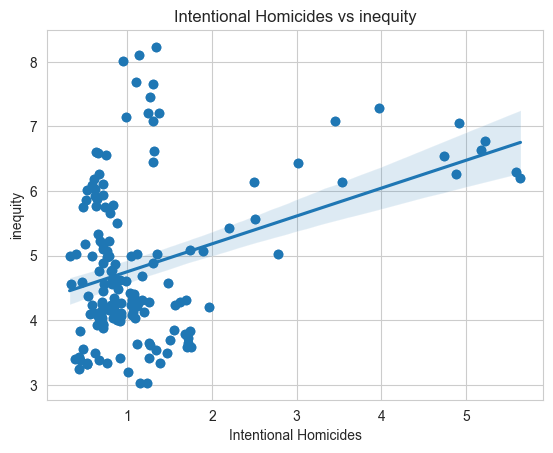

In [34]:
# Scatter Plot
features = ["poverty", "neet", "education", "unemployment", "income", "inequity"]

for feature in features:
    sns.regplot(x="homicides", y=feature, data=df)
    plt.scatter(df["homicides"], df[feature])
    plt.xlabel("Intentional Homicides")
    plt.ylabel(feature)
    plt.title("Intentional Homicides vs " + feature)
    plt.show()


# Modeling

In [35]:
X = df.drop(columns=["geo", "year", "homicides"])
y = df["homicides"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.31994674599466033

In [36]:
# ANOVA Model
model = ols("homicides ~ poverty + neet + education + unemployment + income + inequity", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq     df          F        PR(>F)
poverty         6.684179    1.0   8.870814  3.364204e-03
neet            0.618172    1.0   0.820399  3.664694e-01
education       7.853098    1.0  10.422128  1.519858e-03
unemployment    1.404029    1.0   1.863337  1.742183e-01
income          1.031169    1.0   1.368501  2.438652e-01
inequity       29.722307    1.0  39.445539  3.243902e-09
Residual      116.792868  155.0        NaN           NaN


In [37]:
X2 = sm.add_constant(df.drop(columns=["geo", "year", "homicides"]))
model = sm.OLS(y, X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              homicides   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     11.59
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           1.06e-10
Time:                        16:53:36   Log-Likelihood:                -203.37
No. Observations:                 162   AIC:                             420.7
Df Residuals:                     155   BIC:                             442.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.6717      0.433     -1.553   

In [38]:
hypothesis_0 = "poverty = 0, neet = 0, education = 0, unemployment = 0, income = 0, inequity = 0"
print(results.wald_test(hypothesis_0))


<F test: F=array([[11.59027404]]), p=1.0615514012511982e-10, df_denom=155, df_num=6>


C:\Workspace\test\venv\Lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


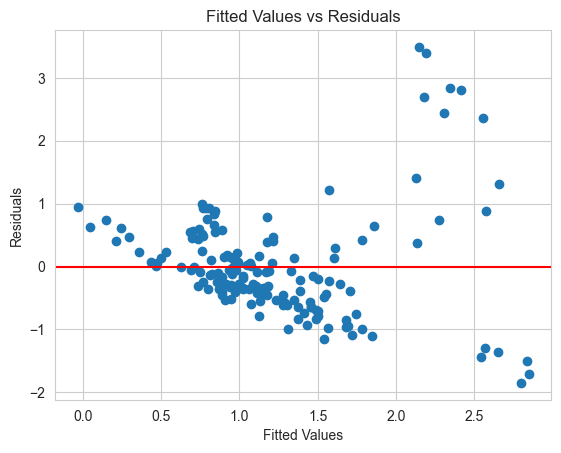

In [39]:
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs Residuals")
plt.axhline(y=0, color="red")
plt.show()

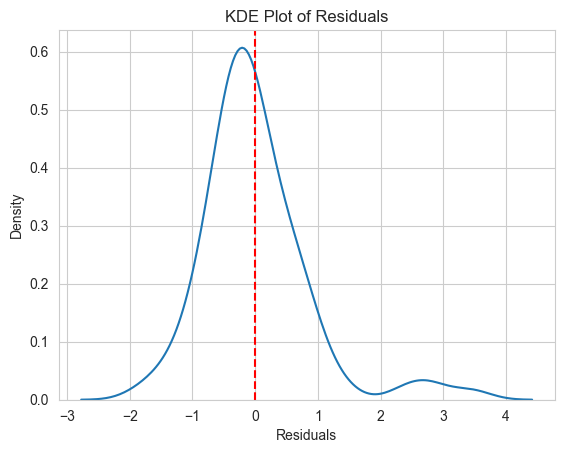

In [40]:
# KDE Plot of residuals
sns.kdeplot(results.resid)
plt.axvline(results.resid.mean(), linestyle='dashed', color="red")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("KDE Plot of Residuals")
plt.show()

In [41]:
#sm.graphics.plot_partregress_grid(results)

### Top 5 regions with the highest intentional homicide in total

In [42]:
data = df.drop(columns=["poverty", "neet", "education", "unemployment", "income", "inequity"])
display(data.groupby("geo").sum().sort_values(by="homicides", ascending=False).head(5))

,year,homicides
geo,,
Latvia,12111,31.25
Lithuania,12111,21.39
Estonia,12111,12.48
Finland,12111,9.73
Belgium,12111,8.76


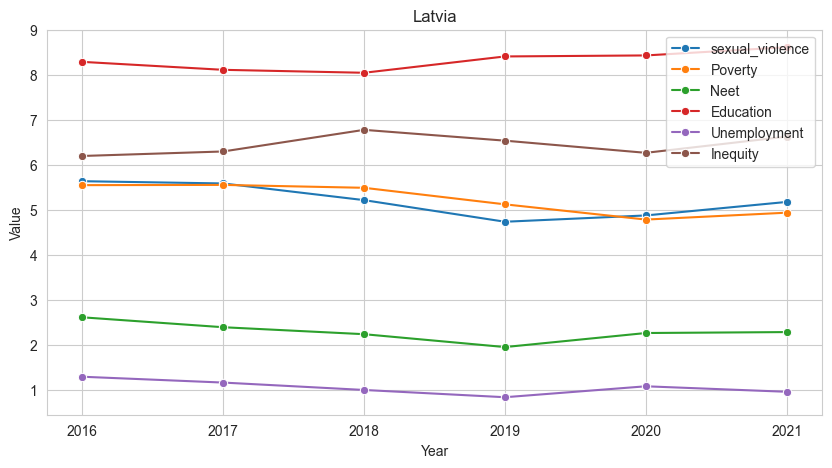

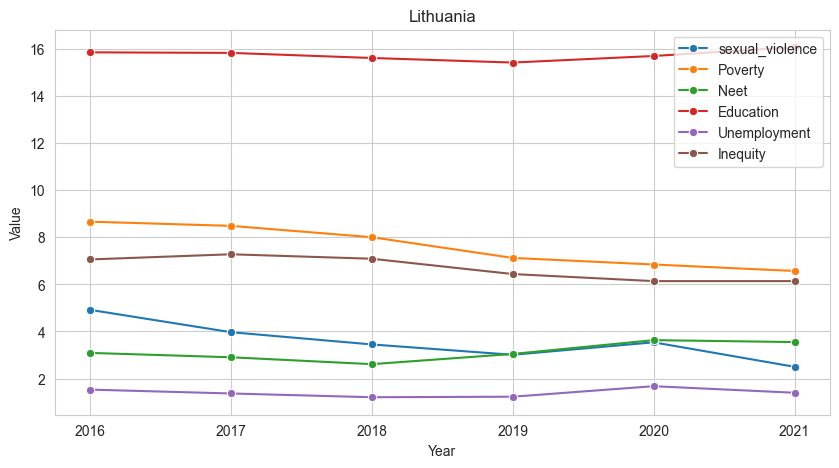

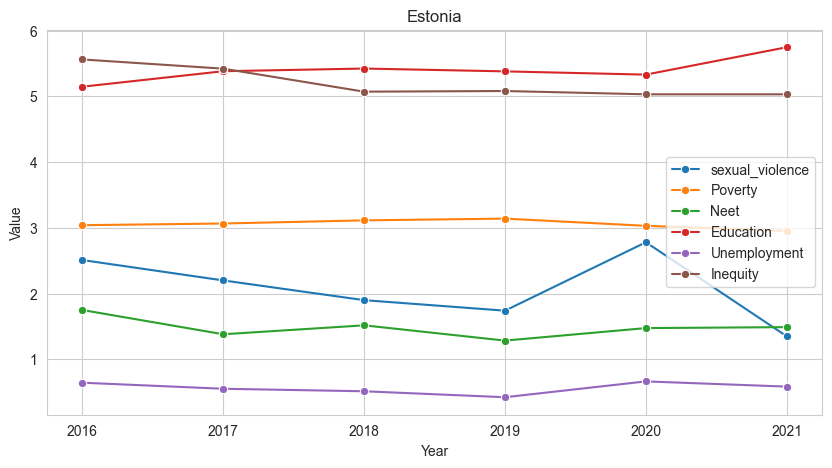

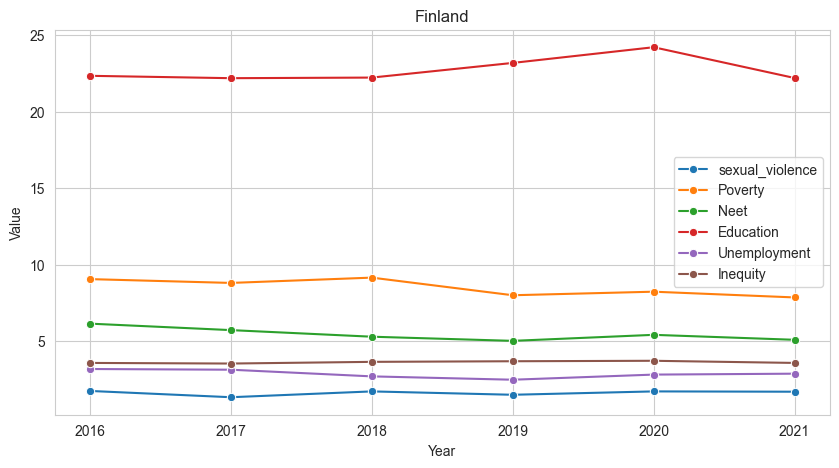

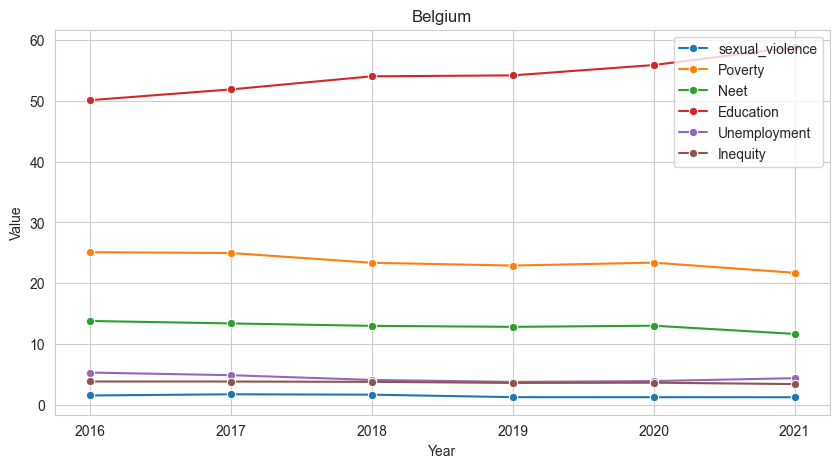

In [43]:
# Data Visualization

latvia = df[df["geo"] == "Latvia"]
lithuania = df[df["geo"] == "Lithuania"]
estonia = df[df["geo"] == "Estonia"]
finland = df[df["geo"] == "Finland"]
belgium = df[df["geo"] == "Belgium"]

countries = [latvia, lithuania, estonia, finland, belgium]

for country in countries:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="year", y="homicides", data=country, label="sexual_violence", marker="o")
    sns.lineplot(x="year", y="poverty", data=country, label="Poverty", marker="o")
    sns.lineplot(x="year", y="neet", data=country, label="Neet", marker="o")
    sns.lineplot(x="year", y="education", data=country, label="Education", marker="o")
    sns.lineplot(x="year", y="unemployment", data=country, label="Unemployment", marker="o")
#    sns.lineplot(x="year", y="income", data=country, label="Income", marker="o")
    sns.lineplot(x="year", y="inequity", data=country, label="Inequity", marker="o")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(country["geo"].iloc[0])
    plt.show()